### Example for HiFi
Before calculating, some parameters(or hyperparameters) are needed to be set in the file *parameters.json*. A detailed description of these parameters is as follows.
- "info"
	+ "root_path": project path, which is the path of *test* dictory in this test project.
	+ "sta_file": file containing station information in the format like that of *data/stations.txt*
	+ "chn_list": channels
- "pi"
	+ "time_segment": segment of time for calculating power integral
	+ "f_range": range of frequencies to be integrated
	+ "f_step": length of each frequency integration segment
	+ "gf_info": informations of istrument response PZ file for each sac file
	+ "raw_data_path": folder of raw sac data
	+ "pi_database_path": folder to store power integral database
- "tele_pir"
	+ "tele_catalog": catalog file of teleseismic events in the format like that of *data/teleseismic_catalog.csv*
	+ "tele_pir_path": folder to store the power integral ratio (PIR) values of the teleseismic events
- "background_pir"
	+ "day_window": number of background days for one teleseismic event
	+ "background_catalog": catalog of the background days
	+ "background_pir_path": folder to store the PIR values of the background days
	+ "background_pir_associated_path": folder to store the background PIR after associating
- "confidence_level"
	+ "cl_path": folder to store the confidence level

The above are the parameters needed to calculate the confidence level.

This package also provides some drawing tools to show the PSD and distribution of background PIR values.
- "plot"
	+ "sta": plot the PSD of the seismograme recorded by this station.
	+ "chn": plot the PSD of this channel.
	+ "event_data_path": folder to store the waveform of teleseismic events after removing the response, which is used to plot the PSD.
	+ "psd_figure_path": folder to store the figures of PSD.
	+ "background_pir_figure_path": folder to store the figures of the background PIR distribution.

Because most of the reasearches about dynamic triggering concern peak dynamic stress, we provides a tool to calculate it.
- "stress"
	+ "shear_wave_velocity": velocity of the shear wave.
	+ "shear_modulus": shear modulus (default value is 3e4 MPa) 
	+ "event_data_path": folder to store the waveform of teleseismic events after removing the response containing the peak ground velocity.
	+ "peak_dynamic_stress_file": File to record the results of peak dynamic stress.

Noted that the parameters for plotting and calculate peak dynamic stress are not necessary. If you don't want to use these functions, the values of these parameters are not needed to be filled in. But, do not delete the key wards of these parameters.

Now, let's run it!

First, define a HiFi instance.

In [9]:
import os
import json

from dyntrigger.hifi.HiFi import HiFi
from dyntrigger.utils.preprocess_tele_catalog import begin_v_end_v

os.chdir("/Users/yunnaidan/Project/Dynamic_triggering/_source/test/bin")
hypers_f = open('parameters.json', 'r', encoding='utf-8')
hypers = json.load(hypers_f)

detector = HiFi(hypers)

The next calculation can be divided into 4 parts, and the results of each part will be stored.

#### Part 1. Build a database of the power integrals
This part contains most of the calculations for the project, So it only has a parallel framework. The number of processes *cores* should be set here, which depends on the compute device. Note that *cores* can still be set to 1 although this is a parallel framework.

In [10]:
my_cores = 2
detector.net_pi(cores=my_cores)

CI.ADO BHZ
Calculate CI.ADO.BHZ in 2009


Now we have a database for testing different parameters in subsequent calculations.

#### Part 2. Calculate the PIR values of teleseismic earthquakes
A catalog of teleseismic events is needed, e.g. *data/teleseismic_catalog.csv*. The basic informations of "time", "latitude", "longitude", "depth", "mag" is nesseary and can be obtained from IRIS or USGS. Moreover, the upper ("f_max") and lower ("f_min") limits of frequency for integrals, length of frequency bin ("f_step") in the power integral database, begin and end times of T_b and T_e windows and distance between the teleseismic event and the research area need to be set in the catalog. For example, the frequency bin is 5 if the "f_win_list" is [[5, 10], [10, 15], [15, 20]].
Here, we provide a method to select the T_b and T_e windows, which is five hours for T_b and T_e is between arrivals of two teleseismic waves with speeds of 5 and 2 km/s. The function *Bvel_Evel* is the inplement of this kind of windows.

In [12]:
Tb = 18000
vel_B = 5.0
vel_E = 2.0
ref_lat = 35.81574
ref_lon = -117.59751
begin_v_end_v(os.path.join(hypers['info']['root_path'],hypers['tele_pir']['tele_catalog']), 
          ref_lat, ref_lon, Tb, vel_B, vel_E)

After preparing the catalog, we can start calculation the PIR values of teleseismic earthquakes.

In [13]:
detector.net_tele_pir(cores=my_cores)

Calculate pir of 2009-01-03T19:43:50.650000Z


#### Part 2. Calculate the PIR values of teleseismic earthquakes

In [14]:
detector.gen_background_catalog()

Background days for: 2009-01-03T19:43:50.650000Z


Then, calculate the PIR values.

In [15]:
detector.net_background_pir(cores=my_cores)

Calculate pir of 2009-01-02T19:43:50.650000Z
Calculate pir of 2009-01-04T19:43:50.650000Z


At the end of this section, we need to match the PIR of the teleseismic event with the PIRs of corresponding background days.

In [16]:
detector.net_background_pir_asso(cores=my_cores)

Associate data of 2009-01-03T19:43:50.650000Z


#### Part 4. Calculate the confidence levels

In [17]:
detector.net_cl(cores=my_cores)

Calculate cl of 2009-01-03T19:43:50.650000Z


Calculation of confidence level is over. Next, I will show you how to use the tools to plot PSD and background PIR distribution.

#### Tool 1. Plotting
After filling in the parameter values in parameter file, just run the following:

Plot 2009-01-03T19:43:50.650000Z...


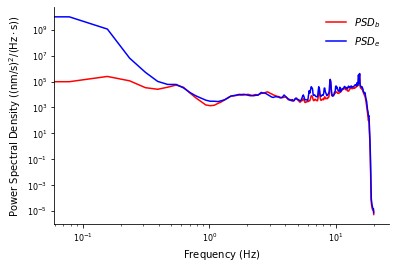

In [18]:
detector.show_psd()
detector.show_bg_pir()

#### Tool 2. Peak dynamic stress
After filling in the parameter values in parameter file, just run the following:

In [19]:
detector.cal_peak_dynamic_stress()

Plot 2009-01-03T19:43:50.650000Z...


Noted that the default setting asks the number of background PIR values ​​should be larger than 30. Here, to simplify the test data, we just chose two background days, so the distribution cannot be drawn.